In [1]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_size = 224

In [4]:
df_data = pd.read_csv("/content/drive/MyDrive/ODIR-5K/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df_data[df_data.D==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg


In [6]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head(6)

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy
5,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...


In [7]:
df_data2['Left-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')

0       False
1       False
2       False
3       False
4        True
        ...  
6387    False
6388     True
6389    False
6390    False
6391    False
Name: Left-Diagnostic Keywords, Length: 6392, dtype: bool

In [8]:
img_dir = "/content/drive/MyDrive/ODIR-5K/ODIR images"

In [9]:
df_data2[df_data2['Left-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy
10,60,Female,11_left.jpg,11_right.jpg,moderate non proliferative retinopathy，hyperte...,moderate non proliferative retinopathy，hyperte...
21,63,Female,26_left.jpg,26_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy，abnorma...
35,55,Female,44_left.jpg,44_right.jpg,moderate non proliferative retinopathy，laser spot,moderate non proliferative retinopathy
37,66,Male,46_left.jpg,46_right.jpg,moderate non proliferative retinopathy,pathological myopia


In [10]:
df_left_ret = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
print(len(df_left_ret))

850


In [11]:
df_data[df_data['Right-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
10,11,60,Female,11_left.jpg,11_right.jpg,moderate non proliferative retinopathy，hyperte...,moderate non proliferative retinopathy，hyperte...,0,1,0,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",11_right.jpg
21,26,63,Female,26_left.jpg,26_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy，abnorma...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",26_right.jpg


In [12]:
df_rt_ret = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
print(len(df_rt_ret))

898


In [13]:
df_ret_filenames = df_left_ret['Left-Fundus'].append(df_rt_ret['Right-Fundus'], ignore_index=True)
df_ret_filenames.head()


0     5_left.jpg
1    11_left.jpg
2    26_left.jpg
3    44_left.jpg
4    46_left.jpg
dtype: object

In [14]:
print(len(df_ret_filenames))


1748


(512, 512, 3)
44_left.jpg


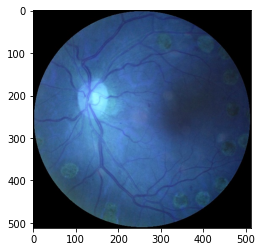

In [15]:
img = df_ret_filenames[3]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

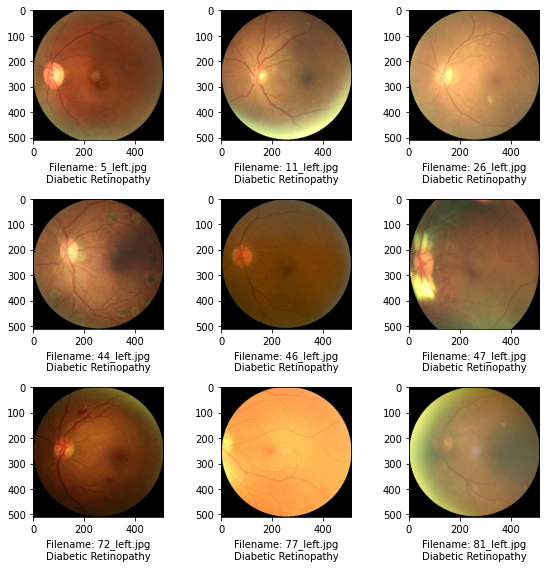

In [16]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_ret_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Diabetic Retinopathy'.format(df_ret_filenames[i]))

plt.tight_layout() 

In [17]:
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [18]:
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [19]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [20]:
df_norm_filenames_random = df_norm_filenames.sample(n = 1748)
df_norm_filenames_random.head()

3672    2907_right.jpg
1571      822_left.jpg
2183     2852_left.jpg
262      2237_left.jpg
4413     954_right.jpg
dtype: object

In [21]:
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       2907_right.jpg
1         822_left.jpg
2        2852_left.jpg
3        2237_left.jpg
4        954_right.jpg
             ...      
1743    2430_right.jpg
1744     170_right.jpg
1745    2375_right.jpg
1746    2707_right.jpg
1747    2913_right.jpg
Length: 1748, dtype: object

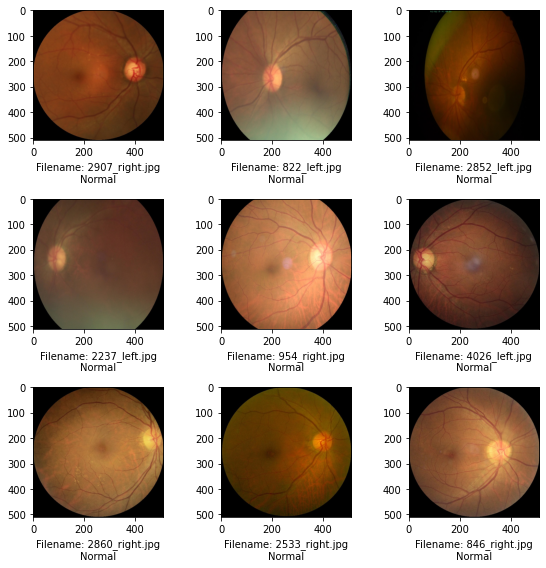

In [22]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [23]:
df_ret_filenames = pd.DataFrame(df_ret_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_ret_filenames["label"] = "diabetic retinopathy"

df_ret_filenames.head()

,filename,label
0,5_left.jpg,diabetic retinopathy
1,11_left.jpg,diabetic retinopathy
2,26_left.jpg,diabetic retinopathy
3,44_left.jpg,diabetic retinopathy
4,46_left.jpg,diabetic retinopathy


In [24]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2907_right.jpg,normal
1,822_left.jpg,normal
2,2852_left.jpg,normal
3,2237_left.jpg,normal
4,954_right.jpg,normal


In [25]:
df_combined = df_ret_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

,filename,label
0,5_left.jpg,diabetic retinopathy
1,11_left.jpg,diabetic retinopathy
2,26_left.jpg,diabetic retinopathy
3,44_left.jpg,diabetic retinopathy
4,46_left.jpg,diabetic retinopathy
...,...,...
3491,2430_right.jpg,normal
3492,170_right.jpg,normal
3493,2375_right.jpg,normal
3494,2707_right.jpg,normal


In [26]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,3011_left.jpg,normal
1,825_right.jpg,diabetic retinopathy
2,93_right.jpg,diabetic retinopathy
3,2726_left.jpg,normal
4,3261_right.jpg,normal
...,...,...
3491,2923_left.jpg,normal
3492,2200_right.jpg,diabetic retinopathy
3493,699_right.jpg,diabetic retinopathy
3494,2533_right.jpg,normal


In [27]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

3496
2797
699


In [28]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [29]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [30]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 2238 validated image filenames belonging to 2 classes.
Found 559 validated image filenames belonging to 2 classes.
Found 699 validated image filenames belonging to 2 classes.


In [31]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [32]:
train_labels[0]

array([1., 0.], dtype=float32)

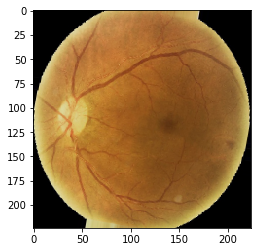

In [33]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

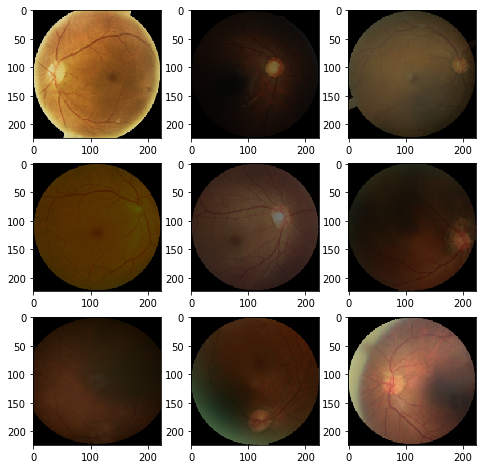

In [34]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 


In [38]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers[0:-10]:
    layer.trainable = False
    
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [40]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

69 17


In [41]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint])

Epoch 1/30
69/69 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.5113
Epoch 1: val_accuracy improved from -inf to 0.52574, saving model to vgg16_1.h5
69/69 [==============================] - 127s 2s/step - loss: 0.7222 - accuracy: 0.5113 - val_loss: 0.6916 - val_accuracy: 0.5257
Epoch 2/30
69/69 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5122
Epoch 2: val_accuracy did not improve from 0.52574
69/69 [==============================] - 61s 863ms/step - loss: 0.6980 - accuracy: 0.5122 - val_loss: 0.6944 - val_accuracy: 0.4816
Epoch 3/30
69/69 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5068
Epoch 3: val_accuracy improved from 0.52574 to 0.58272, saving model to vgg16_1.h5
69/69 [==============================] - 63s 873ms/step - loss: 0.6950 - accuracy: 0.5068 - val_loss: 0.6897 - val_accuracy: 0.5827
Epoch 4/30
69/69 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5281
Epoch 4: val_acc

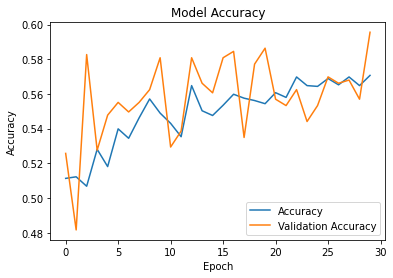

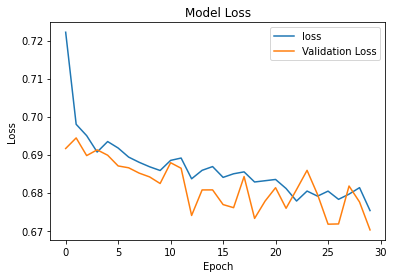

In [42]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [43]:
test_generator.reset()

In [44]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

<ipython-input-44-f4d95dc2fe8f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


21/21 [==============================] - 66s 3s/step


In [45]:
print(pred[0:10])

[[0.69643205 0.30356792]
 [0.4966017  0.5033983 ]
 [0.63420546 0.36579448]
 [0.62409276 0.37590724]
 [0.66799396 0.332006  ]
 [0.72542334 0.27457663]
 [0.60250646 0.39749357]
 [0.6588726  0.34112734]
 [0.7864462  0.2135538 ]
 [0.4429004  0.5570996 ]]


In [46]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[0 1 0 0 0 0 0 0 0 1]


In [47]:
print(len(predicted_class_idx))

699


In [48]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

22/22 [==============================] - 7s 198ms/step - loss: 0.6810 - accuracy: 0.5422


[0.6810050010681152, 0.5422031283378601]

In [49]:
valid_generator.class_indices.items()

dict_items([('diabetic retinopathy', 0), ('normal', 1)])

In [50]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [51]:
pred_labels[1:10]

['normal',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'diabetic retinopathy',
 'normal']

In [52]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,825_right.jpg,diabetic retinopathy
1,3261_right.jpg,normal
2,2424_right.jpg,diabetic retinopathy
3,4229_right.jpg,diabetic retinopathy
4,2668_right.jpg,diabetic retinopathy


In [53]:
prediction_df.iloc[35]

Filename              975_left.jpg
Prediction    diabetic retinopathy
Name: 35, dtype: object

In [54]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

975_left.jpg
1


In [55]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'diabetic retinopathy': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   diabetic retinopathy    diabetic retinopathy      825_right.jpg
 Correct   normal    normal      3261_right.jpg
 Wrong     diabetic retinopathy    normal      2424_right.jpg
 Correct   diabetic retinopathy    diabetic retinopathy      4229_right.jpg
 Wrong     diabetic retinopathy    normal      2668_right.jpg
 Wrong     diabetic retinopathy    normal      3100_left.jpg
 Correct   diabetic retinopathy    diabetic retinopathy      4519_right.jpg
 Wrong     diabetic retinopathy    normal      4644_right.jpg
 Correct   diabetic retinopathy    diabetic retinopathy      948_right.jpg
 Correct   normal    normal      2438_left.jpg
 Wrong     diabetic retinopathy    normal      2402_left.jpg
 Wrong     diabetic retinopathy    normal      2389_left.jpg
 Correct   diabetic retinopathy    diabetic retinopathy      4420_right.jpg
 Correct   diabetic retinopathy    diabetic retinopathy      677_le

In [56]:
x_test, y_test = test_generator.next()

In [57]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.  

print(len(pred))

32
32
699


In [58]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 0s 229ms/step - loss: 0.6793 - accuracy: 0.6250
loss: 0.6792969703674316
Accuracy: 0.625


In [59]:
test_image_data, test_labels = test_generator.next()

In [60]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [61]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

825_right.jpg
0


'diabetic retinopathy'

In [62]:
test_labels[5]

array([0., 1.], dtype=float32)

In [63]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

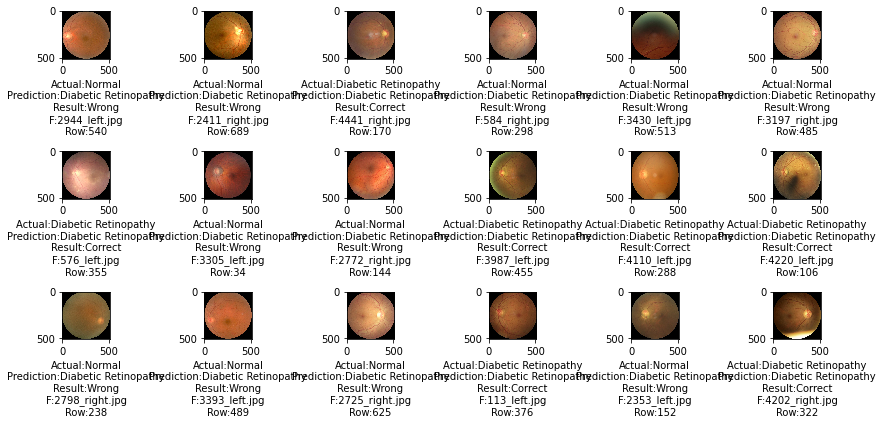

In [64]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 1:
        label = "Normal"
    else:
        label = "Diabetic Retinopathy"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Diabetic Retinopathy"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

In [65]:
print('Classification Report')
target_names = ['Diabetic Retinopathy', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

Diabetic Retinopathy       0.53      0.99      0.69       355
              Normal       0.88      0.08      0.15       344

            accuracy                           0.54       699
           macro avg       0.70      0.54      0.42       699
        weighted avg       0.70      0.54      0.42       699



In [66]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[351,   4],
       [316,  28]])

In [67]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
cm_plot_labels = ['diabetic retinopathy','normal']

Confusion matrix, without normalization
[[351   4]
 [316  28]]


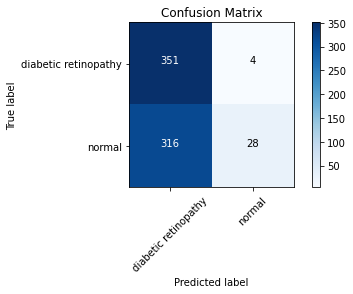

In [69]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')